# Data Overview
_Author : Benjamin Ternot_

## I. Importing Libraries and Global Settings

In [24]:
import os
import gc
import datetime
import random

import IPython
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader as TorchDataLoader, random_split
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

from data_manager.datamanager import DataLoader, DataDisplayer, DataTransformer
from models.model import Unet

In [2]:
IMAGE_SIZE = 64

LIBERATE_MEMORY = True # Delete intermediate object to free memory space

TRAIN_MODEL = True
SAVE_MODEL = True
LOAD_MODEL = not TRAIN_MODEL
MODEL_LOAD_PATH = "models/trained_models/"

MULTI_CHANNEL = True
BATCH_SIZE = 16
EPOCHS = 50
T = 1000
DIM_MULTS = (1, 2, 4)

In [50]:
current_datetime = datetime.datetime.now()
SAVE_PATH = f"images/{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + '4-channels' if MULTI_CHANNEL else '1-channel'
MODEL_SAVE_PATH = f"models/trained_models/{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + ('4-channels' if MULTI_CHANNEL else '1-channel') + "_trained-unet.pt"
PARAMS_SAVE_PATH = f"models/trained_models/{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + ('4-channels' if MULTI_CHANNEL else '1-channel') + "_params.txt"
INPUT_SAVE_PATH = SAVE_PATH + "_batch_input.jpg"
OUTPUT_LOSS_MONITORING_PATH = SAVE_PATH + "_loss_monitoring.jpg"
OUTPUT_SAVE_PATH = SAVE_PATH + "_sampling.jpg"
OUTPUT_ONE_HOT_SAVE_PATH = SAVE_PATH + "_sampling_one-hot.jpg"
OUTPUT_GIF_SAVE_PATH = SAVE_PATH + "_sampling.gif.png"
OUTPUT_GIF_ONE_HOT_SAVE_PATH = SAVE_PATH + "_sampling_one-hot.gif.png"

SAVE_PARAMS = {
    "IMAGE_SIZE": IMAGE_SIZE,
    "MULTI_CHANNEL": MULTI_CHANNEL,
    "BATCH_SIZE": BATCH_SIZE,
    "EPOCHS": EPOCHS,
    "T": T,
    "DIM_MULTS": DIM_MULTS
}

In [4]:
# Write parameters to the file
with open(PARAMS_SAVE_PATH, "w") as file:
    for key, value in SAVE_PARAMS.items():
        file.write(f"{key} = {value}\n")
print(f"Parameters saved to '{PARAMS_SAVE_PATH}'")

Parameters saved to 'models/trained_models/2024-12-09-15-26_4-channels_params.txt'


In [5]:
# Modifier les couleurs des textes et des axes en fonction du thème de Jupyter
DARK_BG = False

if DARK_BG:
    plt.rcParams['text.color'] = 'white'
    plt.rcParams['axes.labelcolor'] = 'white'
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['axes.titlecolor'] = 'white'
else:
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'

In [6]:
# Define the root data folder
root_data_folder = os.path.join(os.path.dirname(os.getcwd()), 'database')

# Define the sub path to the folders containing the data
data_sub_folders = {
    "train": "training",
    "test": "testing",
}

# Define the mapping from group labels to diagnostic classes
group_map = {
    "NOR": "Healthy control",
    "MINF": "Myocardial infarction",
    "DCM": "Dilated cardiomyopathy",
    "HCM": "Hypertrophic cardiomyopathy",
    "RV": "Abnormal right ventricle"
}

## II. Data Loading and Displaying

In [7]:
# Create a DataLoader instance
data_loader = DataLoader(root_data_folder)

# Load the data
for key, sub_folder in data_sub_folders.items():
    data_loader.load_data(sub_folder, name=key, store=True)


Loading data in '/home/infres/bternot-21/PRIM-AI-Diffusion-Models-for-Cardiac-Images/database/training':   0%|…

Loading data in '/home/infres/bternot-21/PRIM-AI-Diffusion-Models-for-Cardiac-Images/database/testing':   0%| …

In [8]:
# Initialize the DataDisplayer with the DataLoader instance
data_displayer = DataDisplayer(data_loader, group_map=group_map)

data_loader.data
├── train
│	├── patient093
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	├── patient077
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	├── ...
├── test
│	├── patient125
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	├── patient117
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	├── ...
##########################################################################################
test data :
	------------------------------------------------------------
	Dilated cardiomyopathy :		
		
			ID: patient122, height: 165.0cm, weight: 65.0kg, group: DCM, nb_frames: 14


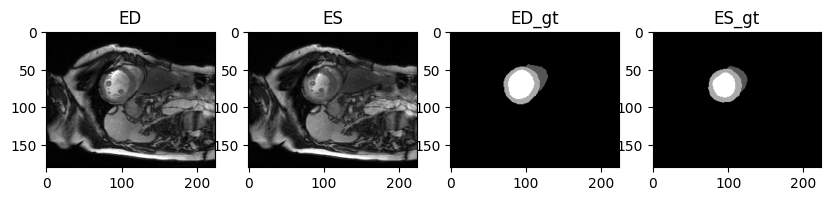

	------------------------------------------------------------
	Hypertrophic cardiomyopathy :		
		
			ID: patient134, height: 185.0cm, weight: 104.0kg, group: HCM, nb_frames: 35


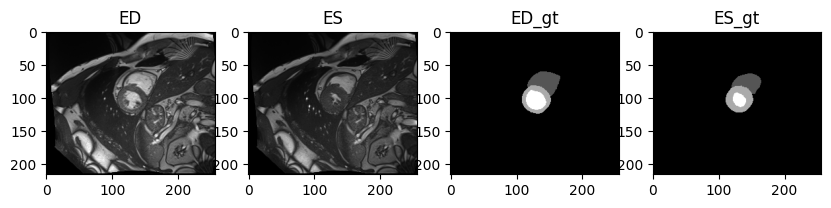

	------------------------------------------------------------
	Myocardial infarction :		
		
			ID: patient112, height: 172.0cm, weight: 90.0kg, group: MINF, nb_frames: 30


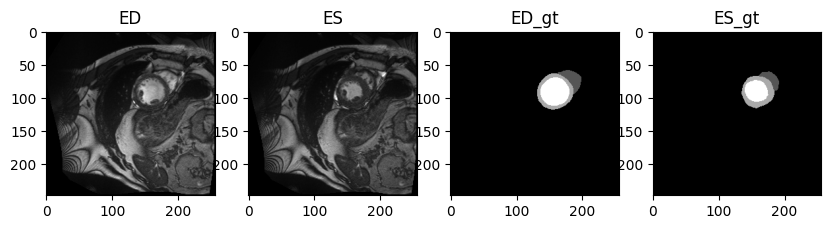

	------------------------------------------------------------
	Healthy control :		
		
			ID: patient110, height: 167.0cm, weight: 116.0kg, group: NOR, nb_frames: 30


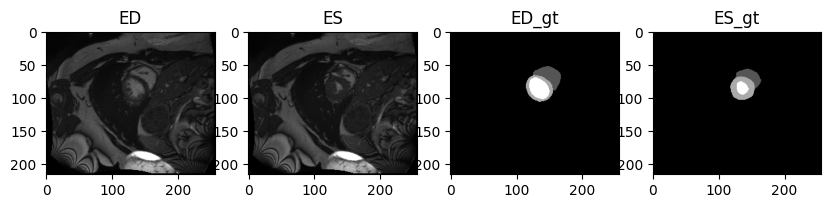

	------------------------------------------------------------
	Abnormal right ventricle :		
		
			ID: patient126, height: 137.0cm, weight: 35.0kg, group: RV, nb_frames: 15


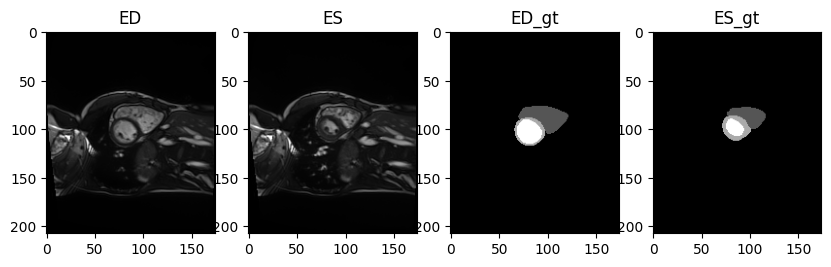

##########################################################################################
train data :
	------------------------------------------------------------
	Dilated cardiomyopathy :		
		
			ID: patient018, height: 161.0cm, weight: 79.0kg, group: DCM, nb_frames: 13


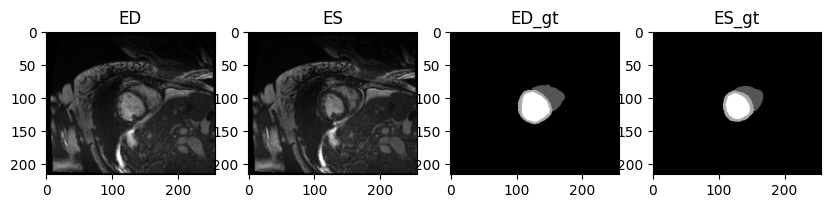

	------------------------------------------------------------
	Hypertrophic cardiomyopathy :		
		
			ID: patient022, height: 165.0cm, weight: 42.0kg, group: HCM, nb_frames: 28


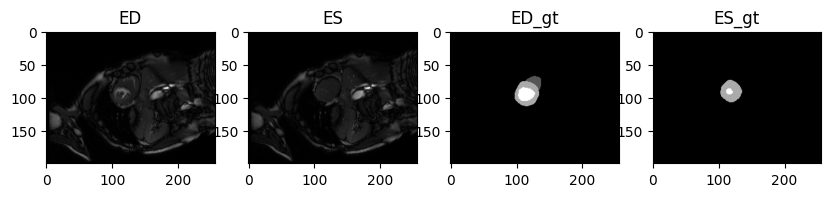

	------------------------------------------------------------
	Myocardial infarction :		
		
			ID: patient051, height: 170.0cm, weight: 91.0kg, group: MINF, nb_frames: 30


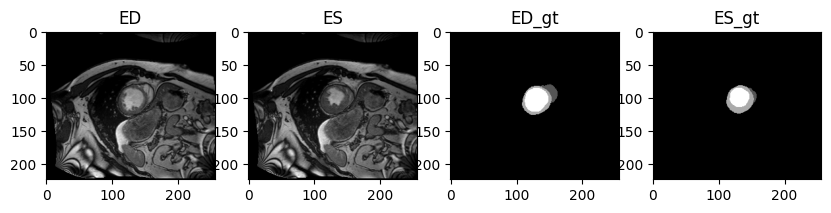

	------------------------------------------------------------
	Healthy control :		
		
			ID: patient080, height: 155.0cm, weight: 74.0kg, group: NOR, nb_frames: 21


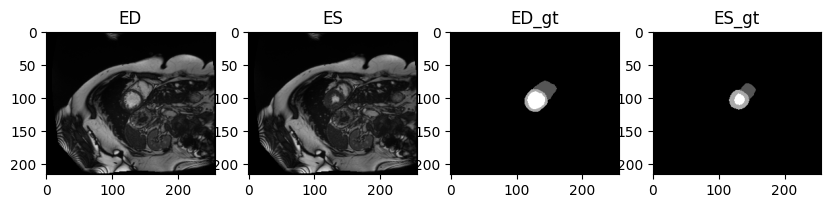

	------------------------------------------------------------
	Abnormal right ventricle :		
		
			ID: patient090, height: 150.0cm, weight: 66.0kg, group: RV, nb_frames: 12


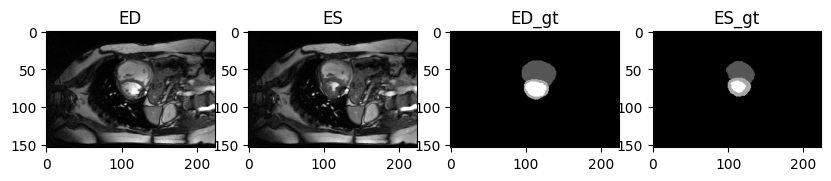

In [9]:
# Display as an arborescence the dataloader.data dictionary
print(data_displayer.display_data_arborescence('data_loader.data', max_keys={1: 2}))

# Display some examples
data_displayer.display_examples(nb_examples=1, per_combination=True, sort_by=('data_name', 'group', 'id'), format_sep=('#' * 90, '-' * 60, ''), format_categories=('{} data :\n', '{} :', '\n'))

## III. Data Overview

There are 74 different shapes in the data
X axis varies from 154 to 428
Y axis varies from 154 to 512
Z axis varies from 6 to 21
Aspect ratio (X/Y) varies from 0.6388888888888888 to 1.4545454545454546


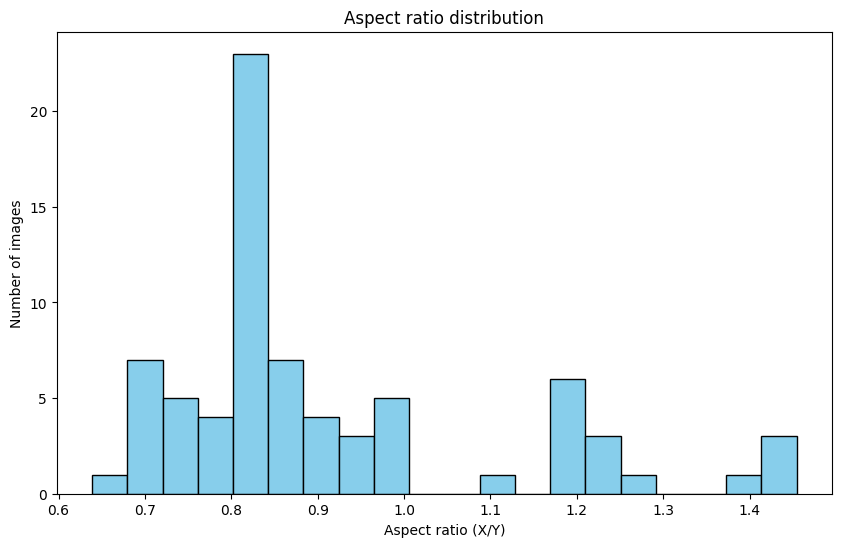

In [10]:
# Show repartition of shape of the images
shape_dict = {}
for dataset_key, dataset in data_loader.data.items():
    for patient, patient_data in dataset.items():
        for image_name, image in patient_data['image_data'].items():
            shape = image.shape
            if shape not in shape_dict:
                shape_dict[shape] = 1
            else:
                shape_dict[shape] += 1

print(
    f'There are {len(shape_dict)} different shapes in the data'
    f'\nX axis varies from {min([shape[0] for shape in shape_dict.keys()])} to {max([shape[0] for shape in shape_dict.keys()])}'
    f'\nY axis varies from {min([shape[1] for shape in shape_dict.keys()])} to {max([shape[1] for shape in shape_dict.keys()])}'
    f'\nZ axis varies from {min([shape[2] for shape in shape_dict.keys()])} to {max([shape[2] for shape in shape_dict.keys()])}'
    f'\nAspect ratio (X/Y) varies from {min([shape[0] / shape[1] for shape in shape_dict.keys()])} to {max([shape[0] / shape[1] for shape in shape_dict.keys()])}'
)
# plot the repartition of the aspect ratio
plt.figure(figsize=(10, 6))
plt.hist([shape[0] / shape[1] for shape in shape_dict.keys()], bins=20, color='skyblue', edgecolor='black')
plt.title('Aspect ratio distribution')
plt.xlabel('Aspect ratio (X/Y)')
plt.ylabel('Number of images')
plt.show()

## IV. Preprocessing

In [11]:
# Instanciate the data transformer
data_transformer = DataTransformer(data_loader)

In [12]:
# Resize the images to a common shape
target_shape = (IMAGE_SIZE, IMAGE_SIZE)
data_transformer.crop_and_resize(target_shape=target_shape, padding=0.2, output_key='image_resized_data', keep_3d_consistency=False, link_gt_to_data=False, create_channels_from_gt=MULTI_CHANNEL, image_names=['ED_gt', 'ES_gt'])

# Display tree of the data after resizing
print(data_displayer.display_data_arborescence('data_loader.data', max_keys=7))

Transforming images in 'train':   0%|          | 0/100 [00:00<?, ?it/s]

Transforming images in 'test':   0%|          | 0/50 [00:00<?, ?it/s]

data_loader.data
├── train
│	├── patient093
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	│	├── image_resized_data
│	│	│	├── ED_gt
│	│	│	├── ES_gt
│	├── patient077
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	│	├── image_resized_data
│	│	│	├── ED_gt
│	│	│	├── ES_gt
│	├── patient099
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	│	├── image_resized_data
│	│	│	├── ED_gt
│	│	│	├── ES_gt
│	├── patient038
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	│	├── image_resized_data
│	│	│	├── ED_gt
│	│	│	├── ES_gt
│	├── patient032
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	

##########################################################################################
test data :
	------------------------------------------------------------
	Dilated cardiomyopathy :		
		
			ID: patient149, height: 173.0cm, weight: 70.0kg, group: DCM, nb_frames: 25


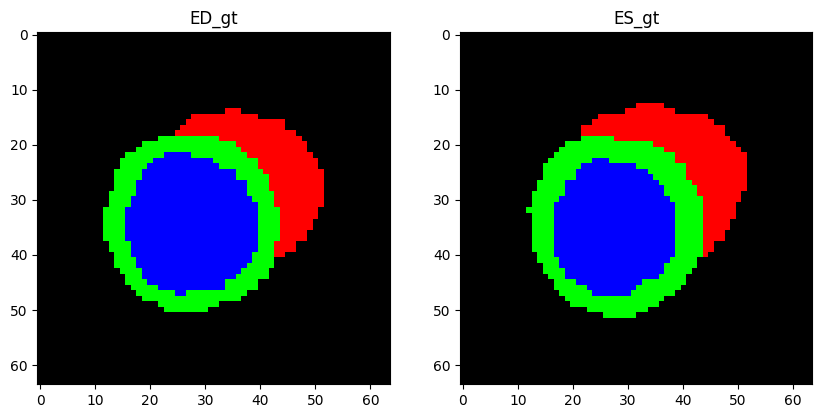

	------------------------------------------------------------
	Hypertrophic cardiomyopathy :		
		
			ID: patient142, height: 160.0cm, weight: 98.0kg, group: HCM, nb_frames: 30


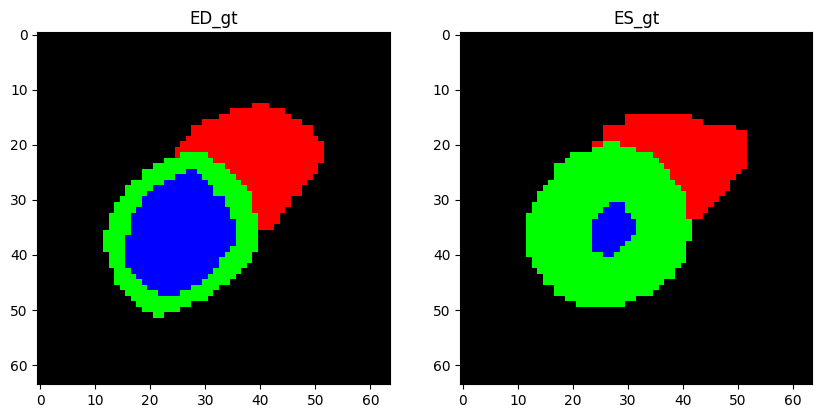

	------------------------------------------------------------
	Myocardial infarction :		
		
			ID: patient115, height: 165.0cm, weight: 92.0kg, group: MINF, nb_frames: 30


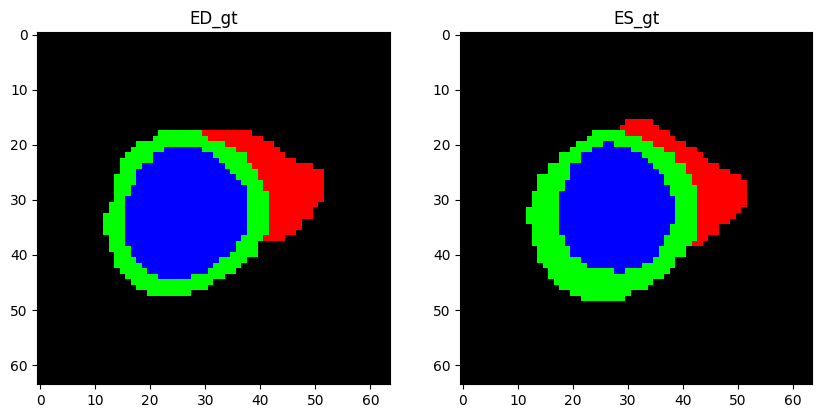

	------------------------------------------------------------
	Healthy control :		
		
			ID: patient123, height: 170.0cm, weight: 70.0kg, group: NOR, nb_frames: 30


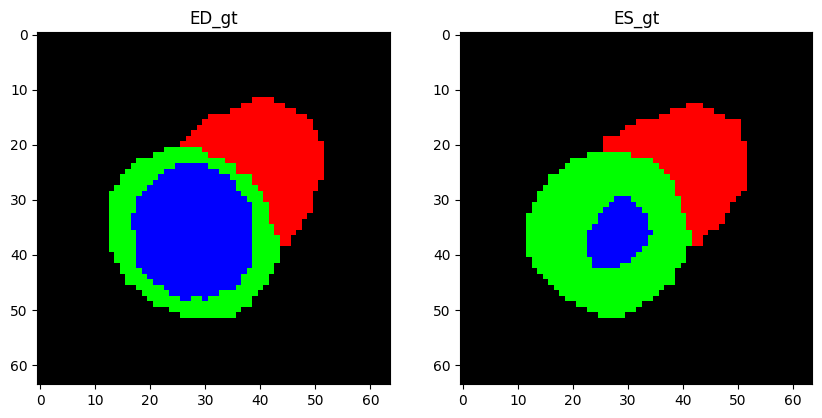

	------------------------------------------------------------
	Abnormal right ventricle :		
		
			ID: patient121, height: 183.0cm, weight: 75.0kg, group: RV, nb_frames: 35


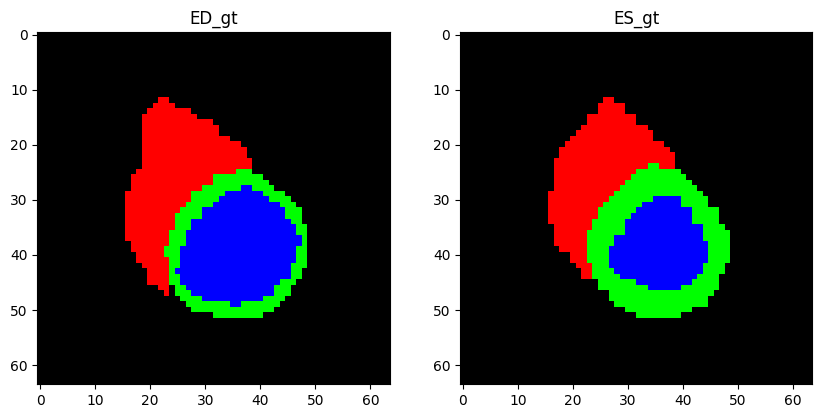

##########################################################################################
train data :
	------------------------------------------------------------
	Dilated cardiomyopathy :		
		
			ID: patient010, height: 170.0cm, weight: 68.0kg, group: DCM, nb_frames: 28


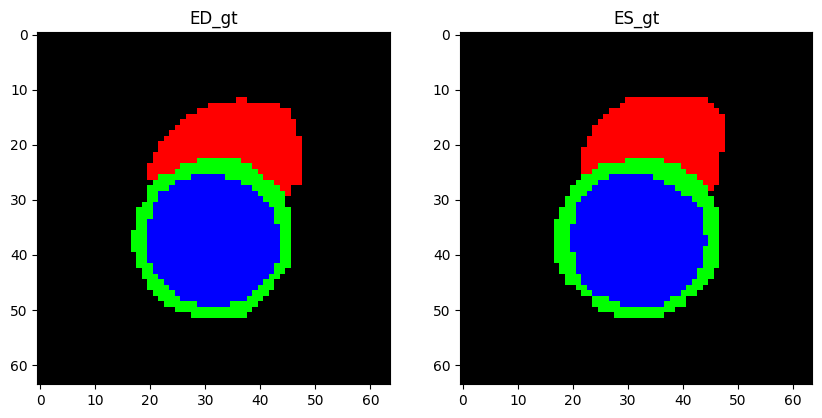

	------------------------------------------------------------
	Hypertrophic cardiomyopathy :		
		
			ID: patient032, height: 186.0cm, weight: 123.0kg, group: HCM, nb_frames: 30


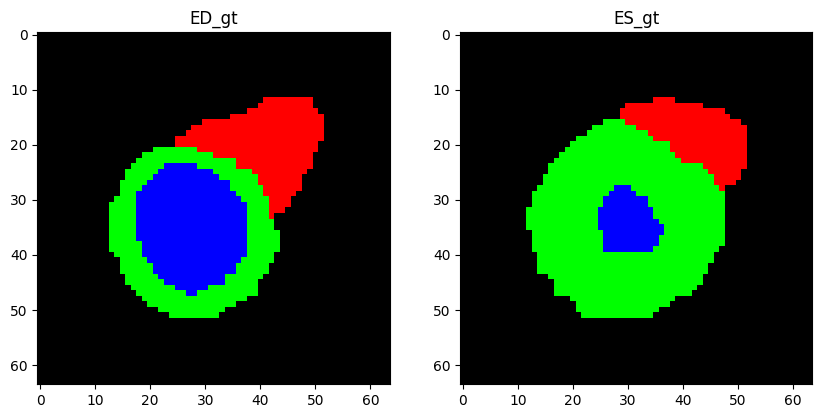

	------------------------------------------------------------
	Myocardial infarction :		
		
			ID: patient046, height: 186.0cm, weight: 74.0kg, group: MINF, nb_frames: 30


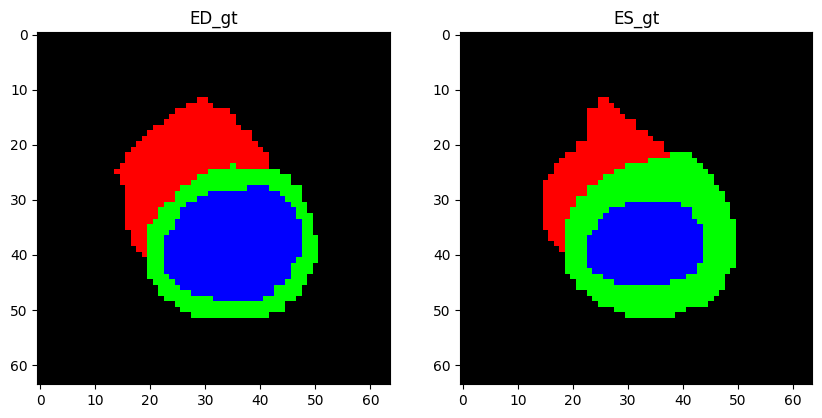

	------------------------------------------------------------
	Healthy control :		
		
			ID: patient076, height: 175.0cm, weight: 87.0kg, group: NOR, nb_frames: 30


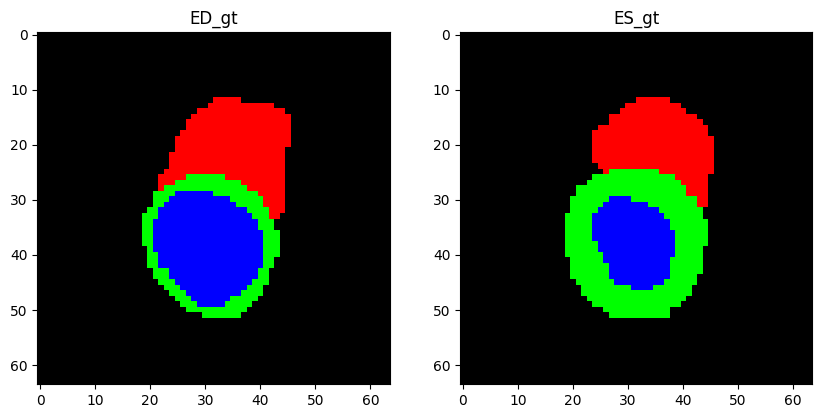

	------------------------------------------------------------
	Abnormal right ventricle :		
		
			ID: patient082, height: 183.0cm, weight: 82.0kg, group: RV, nb_frames: 17


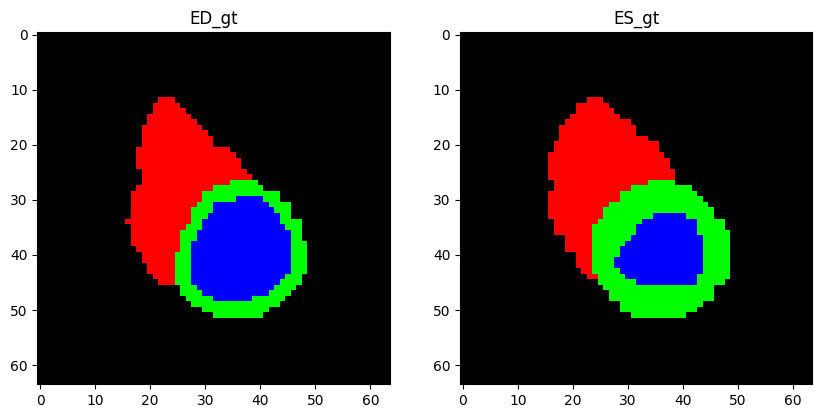

In [13]:
# Display some examples for the resized images
data_displayer.display_examples(image_type='image_resized_data', image_names=['ED_gt', 'ES_gt'], nb_examples=1, per_combination=True, sort_by=('data_name', 'group', 'id'), format_sep=('#' * 90, '-' * 60, ''), format_categories=('{} data :\n', '{} :', '\n'))

## V. Data Augmentation

In [14]:
transformed_images_gt = data_loader.extract_specific_images(image_types=['image_resized_data'], image_names=['ED_gt', 'ES_gt'])
rotated_images = []
nb_rotations = 7
max_angle = 45
for angle in tqdm(np.linspace(-max_angle, max_angle, nb_rotations), desc='Rotating images'):
    if angle == 0:
        rotated_images.append(transformed_images_gt)
    else:
        rotated_images.append(DataTransformer.rotate_images(angle=angle, images=transformed_images_gt, has_channels=transformed_images_gt[0].shape[0] > 3))
# concatenate all lists
rotated_images = [images for sublist in rotated_images for images in sublist]
print(f'Number of images after rotation: {len(rotated_images)}')

Extracting images in 'train':   0%|          | 0/100 [00:00<?, ?it/s]

Extracting images in 'test':   0%|          | 0/50 [00:00<?, ?it/s]

Rotating images:   0%|          | 0/7 [00:00<?, ?it/s]

Number of images after rotation: 2100


## Model Diffusion Process

In [15]:
DEVICE = torch.device("cuda:1") if torch.cuda.is_available() else "cpu"

## Preprocessing

In [16]:
# Dataset parameters
batch_size = BATCH_SIZE

In [21]:
all_images = data_transformer.slice_depth_images(rotated_images)
# Keep a multiple of batch_size images
all_images = all_images[:(len(all_images)//batch_size)*batch_size]
all_images = DataTransformer.one_hot_encode_batch(all_images)
print(f'Number of images after slicing: {len(all_images)} ({len(all_images)//batch_size} batchs)')

Slicing images:   0%|          | 0/2100 [00:00<?, ?it/s]

Number of images after slicing: 20832 (1302 batchs)


In [22]:
def normalize_dataset(images):
    flat_images = np.concatenate([img.flatten() for img in images])
    scaler = MinMaxScaler(feature_range=(-1., 1.))
    scaler.fit(flat_images.reshape(-1, 1))  # Fit on entire dataset
    return [scaler.transform(img.reshape(-1, 1)).reshape(img.shape) for img in images]
all_images = normalize_dataset(all_images)

In [30]:
train_size = batch_size * int((0.9 * len(all_images)//batch_size)//1)  # 90% for training
val_size = len(all_images) - train_size  # 10% for validation

print(f'{train_size} images ({train_size//batch_size} batchs) for train, {val_size} images ({val_size//batch_size} batchs) for validation. ({train_size/len(all_images):.0%}-{val_size/len(all_images):.0%})')
training_images, val_images = random_split(all_images, [train_size, val_size])

18736 images (1171 batchs) for train, 2096 images (131 batchs) for validation. (90%-10%)


In [31]:
if LIBERATE_MEMORY:
    del shape_dict
    del data_loader
    del data_transformer
    del data_displayer
    del transformed_images_gt
    del rotated_images
    del all_images
    gc.collect()

In [32]:
train_dataloader, channels, image_size, len_dataloader = TorchDataLoader(dataset=training_images, batch_size=batch_size, shuffle=True), training_images[0].shape[0], target_shape[0], len(training_images)//batch_size

def format_batch_shape_string(batch_shape: tuple[int]):
    return "{} image(s), {} channel(s), {} row(s), {} column(s)".format(*batch_shape)

# Get a random batch from the train_dataloader without converting it to a list
random_batch_index = random.randint(0, len(train_dataloader) - 1)
# Use iter and advance to the random index
batch_iterator = iter(train_dataloader)
for _ in range(random_batch_index):
    next(batch_iterator)  # Advance to the random batch
batch_image = next(batch_iterator)  # Get the random batch
print(f"Shape of each batch: [{format_batch_shape_string(batch_image.shape)}]")

Shape of each batch: [16 image(s), 4 channel(s), 64 row(s), 64 column(s)]


In [33]:
def normalize_tensor_per_image(batch):
    # Normalize each image individually in the batch
    batch_normalized = torch.stack([2 * (image - image.min()) / (image.max() - image.min()) - 1 for image in batch])
    return batch_normalized

def show_images(batch, filename=None, one_hot_encode=False):
    image = np.array(torch.permute(make_grid(normalize_tensor_per_image(batch), nrow=int(np.sqrt(len(batch))), padding=0), (1,2,0)).cpu())
    image = (image + np.ones(image.shape))/2.
    if image.shape[-1] > 3:
        if one_hot_encode:
            image = DataDisplayer.one_hot_encode(image)
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        axes[0].imshow(image[..., 1:4])
        axes[0].set_title("RGB Channels")
        axes[0].axis('off')
        im_bg = axes[1].imshow(image[..., 0], cmap='viridis')
        axes[1].set_title("Background Intensity")
        axes[1].axis('off')
        cbar = fig.colorbar(im_bg, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label("Intensity")
        plt.tight_layout()
        if filename:
            fig.savefig(filename)
        plt.show()
    else:
        plt.imshow(image, cmap='gray')
        if filename:
            plt.savefig(filename)
        plt.show()

/tmp/ipykernel_1908448/300600383.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(torch.permute(make_grid(normalize_tensor_per_image(batch), nrow=int(np.sqrt(len(batch))), padding=0), (1,2,0)).cpu())


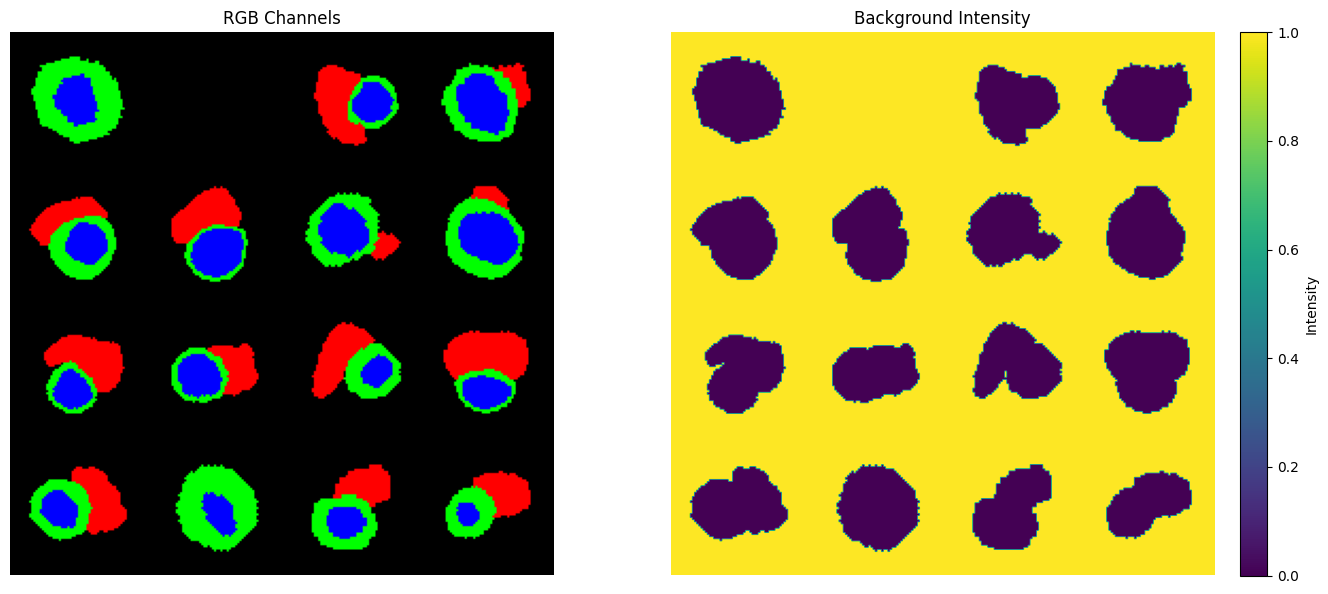

In [51]:
show_images(batch_image[:], INPUT_SAVE_PATH)

## Forward Diffusion

### Beta Scheduling

In [35]:
# Different type of beta schedule
def linear_beta_schedule(timesteps, beta_start = 0.0001, beta_end = 0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


### Constants calculation

In [36]:
# Function to get alphas and betas
def get_alph_bet(timesteps, schedule=cosine_beta_schedule):

    # define beta
    betas = schedule(timesteps)

    # define alphas
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0) # cumulative product of alpha
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)  # corresponding to the prev const
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

    # calculations for diffusion q(x_t | x_{t-1}) and others
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

    # calculations for posterior q(x_{t-1} | x_t, x_0)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    const_dict = {
        'betas': betas,
        'sqrt_recip_alphas': sqrt_recip_alphas,
        'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
        'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod,
        'posterior_variance': posterior_variance
    }

    return const_dict

### Definition of $q(x_t | x_{0})$

In [37]:
# extract the values needed for time t
def extract(constants, batch_t, x_shape):
    diffusion_batch_size = batch_t.shape[0]

    # get a list of the appropriate constants of each timesteps
    out = constants.gather(-1, batch_t.cpu())

    return out.reshape(diffusion_batch_size, *((1,) * (len(x_shape) - 1))).to(batch_t.device)


In [38]:
# forward diffusion (using the nice property)
def q_sample(constants_dict, batch_x0, batch_t, noise=None):
    if noise is None:
        noise = torch.randn_like(batch_x0)

    sqrt_alphas_cumprod_t = extract(constants_dict['sqrt_alphas_cumprod'], batch_t, batch_x0.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        constants_dict['sqrt_one_minus_alphas_cumprod'], batch_t, batch_x0.shape
    )

    return sqrt_alphas_cumprod_t * batch_x0 + sqrt_one_minus_alphas_cumprod_t * noise

timesteps: tensor([  0,  62, 124, 186, 248, 310, 372, 434, 496, 558, 620, 682, 744, 806,
        868, 930])
Original images:


/tmp/ipykernel_1908448/300600383.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(torch.permute(make_grid(normalize_tensor_per_image(batch), nrow=int(np.sqrt(len(batch))), padding=0), (1,2,0)).cpu())


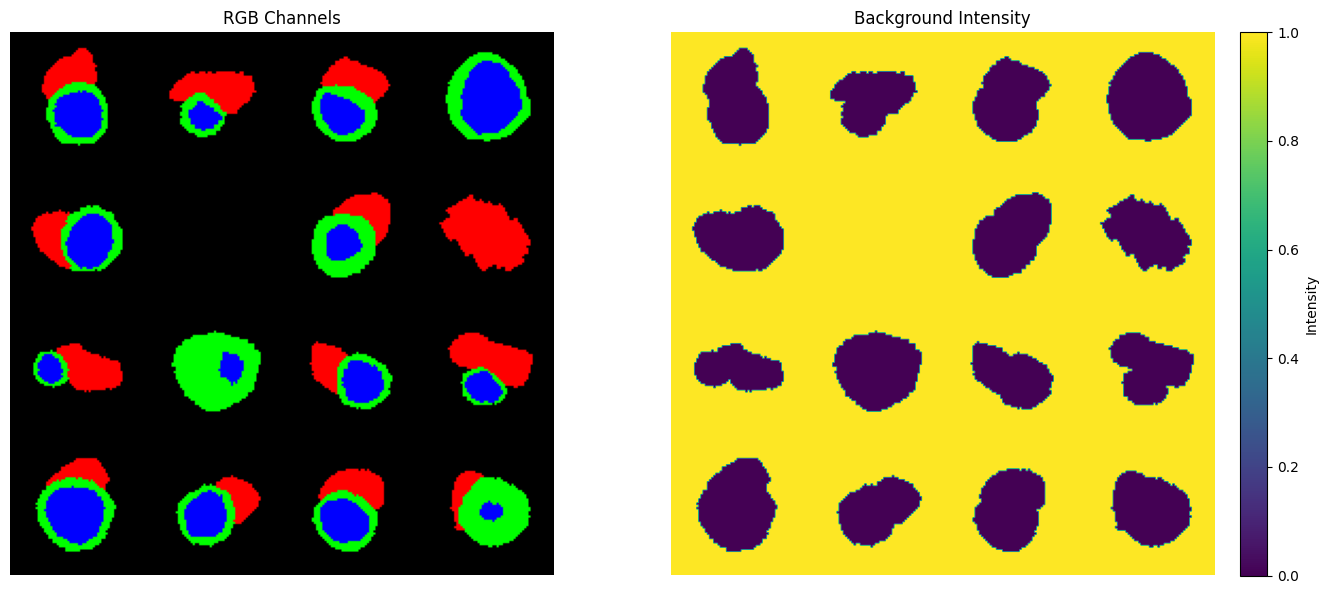

Noised images with linear shedule:


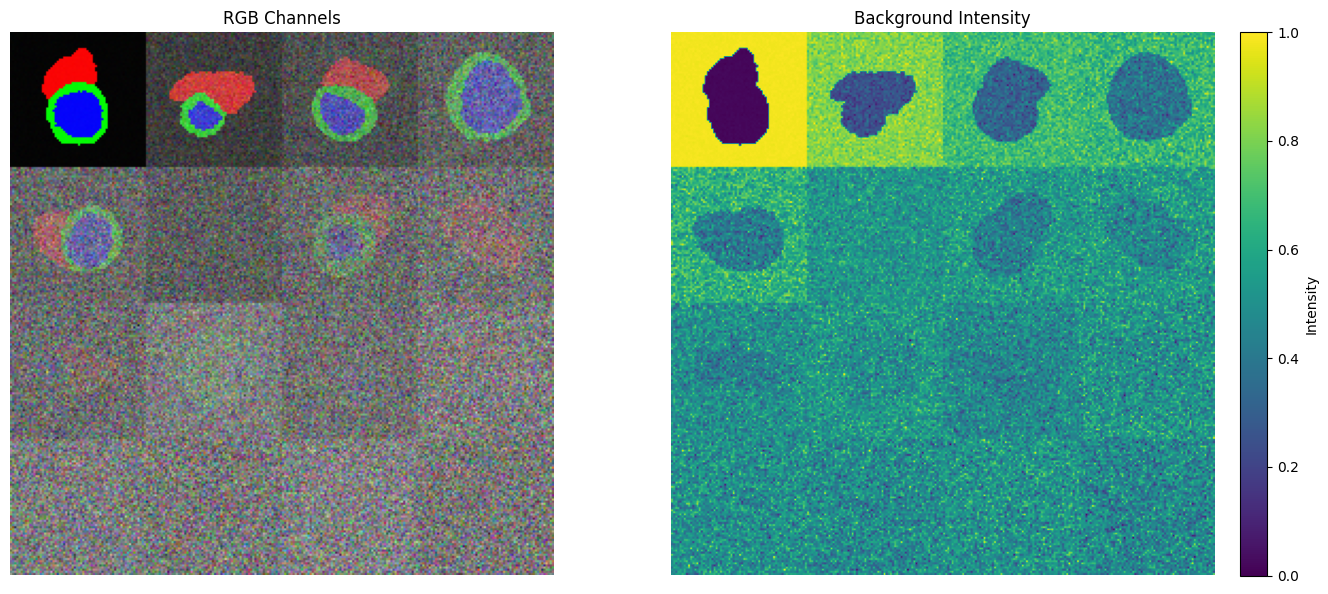

Noised images with cosine shedule:


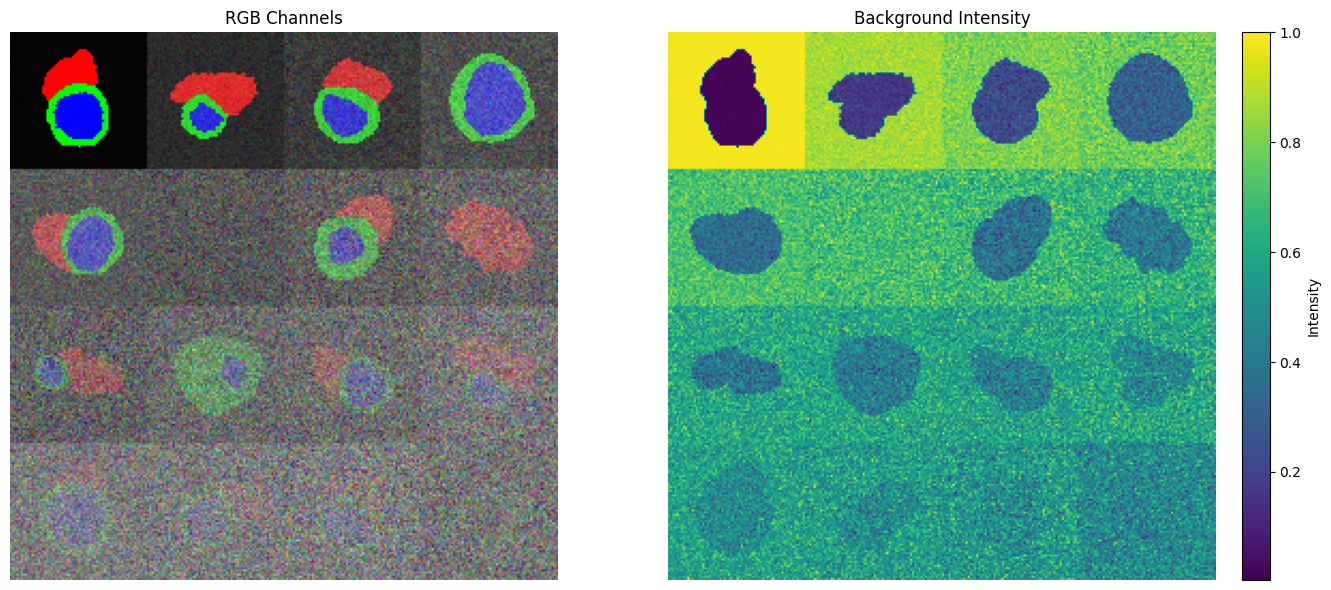

In [39]:
const_linear_dict = get_alph_bet(T, schedule=linear_beta_schedule)
const_cosine_dict = get_alph_bet(T, schedule=cosine_beta_schedule)

batch_t = torch.arange(batch_size)*(T//batch_size)  # get a range of timesteps from 0 to T
print(f"timesteps: {batch_t}")
noisy_batch_linear = q_sample(const_linear_dict, batch_image, batch_t, noise=None)
noisy_batch_cosine = q_sample(const_cosine_dict, batch_image, batch_t, noise=None)

print("Original images:")
show_images(batch_image[:])

print("Noised images with linear shedule:")
show_images(noisy_batch_linear[:])

print("Noised images with cosine shedule:")
show_images(noisy_batch_cosine[:])

## Model Diffusion Process

### Model definition

In [40]:
model = Unet(
        dim=image_size,
        init_dim=None,
        out_dim=None,
        dim_mults=DIM_MULTS,
        channels=channels,
        with_time_emb=True,
        convnext_mult=2,
    ).to(DEVICE)

### Definition of $ p_{\theta}(x_{t-1}|x_t) $

In [41]:
@torch.no_grad()
def p_sample(constants_dict, batch_xt, predicted_noise, batch_t):
    # We first get every constants needed and send them in right device
    betas_t = extract(constants_dict['betas'], batch_t, batch_xt.shape).to(batch_xt.device)
    sqrt_one_minus_alphas_cumprod_t = extract(
        constants_dict['sqrt_one_minus_alphas_cumprod'], batch_t, batch_xt.shape
    ).to(batch_xt.device)
    sqrt_recip_alphas_t = extract(
        constants_dict['sqrt_recip_alphas'], batch_t, batch_xt.shape
    ).to(batch_xt.device)

    # Equation 11 in the ddpm paper
    # Use predicted noise to predict the mean (mu theta)
    model_mean = sqrt_recip_alphas_t * (
        batch_xt - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t
    )

    # We have to be careful to not add noise if we want to predict the final image
    predicted_image = torch.zeros(batch_xt.shape).to(batch_xt.device)
    t_zero_index = (batch_t == torch.zeros(batch_t.shape).to(batch_xt.device))

    # Algorithm 2 line 4, we add noise when timestep is not 1:
    posterior_variance_t = extract(constants_dict['posterior_variance'], batch_t, batch_xt.shape)
    noise = torch.randn_like(batch_xt)  # create noise, same shape as batch_x
    predicted_image[~t_zero_index] = model_mean[~t_zero_index] + (
        torch.sqrt(posterior_variance_t[~t_zero_index]) * noise[~t_zero_index]
    )

    # If t=1 we don't add noise to mu
    predicted_image[t_zero_index] = model_mean[t_zero_index]

    return predicted_image

## Sampling

In [42]:
# Algorithm 2 (including returning all images)
@torch.no_grad()
def sampling(model, shape, T, constants_dict):
    b = shape[0]
    # start from pure noise (for each example in the batch)
    batch_xt = torch.randn(shape, device=DEVICE)

    batch_t = torch.ones(shape[0]) * T  # create a vector with batch-size time the timestep
    batch_t = batch_t.type(torch.int64).to(DEVICE)

    imgs = []

    for t in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        batch_t -= 1
        predicted_noise = model(batch_xt, batch_t)

        batch_xt = p_sample(constants_dict, batch_xt, predicted_noise, batch_t)

        imgs.append(batch_xt.cpu())

    return imgs

## Training

In [45]:
train_dataloader, channels, image_size, len_dataloader = TorchDataLoader(dataset=training_images, batch_size=batch_size, shuffle=True), training_images[0].shape[0], target_shape[0], len(training_images)//batch_size
constants_dict = get_alph_bet(T, schedule=linear_beta_schedule)

val_dataloader = TorchDataLoader(val_images, batch_size=batch_size, shuffle=False)

epochs = EPOCHS

criterion = nn.SmoothL1Loss()
optimizer = Adam(model.parameters(), lr=1e-4)

### Training loop

In [47]:
if TRAIN_MODEL:
    best_val_loss = float('inf')  # Start with an infinitely high loss
    best_model_state = None  # To save the best model
    last_model_state = None  # To save the last model
    best_epoch = 0

    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)

    # Create a fixed `T_val_steps` for validation (choose a specific time step range you want for validation)
    T_val_steps = torch.randint(0, T, (batch_size,), device=DEVICE).long()  # fixed time steps for validation
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in loop:
            optimizer.zero_grad()

            batch_size_iter = batch.shape[0]
            batch_image = batch.to(DEVICE)
            batch_image = normalize_tensor_per_image(batch_image)

            # Algorithm 1 line 3: sample t uniformally for every example in the batch
            batch_t = torch.randint(0, T, (batch_size_iter,), device=DEVICE).long()

            noise = torch.randn_like(batch_image)

            x_noisy = q_sample(constants_dict, batch_image, batch_t, noise=noise)
            predicted_noise = model(x_noisy, batch_t)

            loss = criterion(noise, predicted_noise)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            loop.set_postfix(loss=loss.item())
        train_losses[epoch] = train_loss /len(train_dataloader)

        # After the training loop, calculate validation loss using fixed `T_val_steps`
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # Don't compute gradients for validation
            for batch in val_dataloader:
                batch_image = batch.to(DEVICE)
    
                # Use the fixed `T_val_steps` for validation (the same time steps across all validation batches)
                batch_t = T_val_steps  # Fixed time steps for validation
    
                noise = torch.randn_like(batch_image)
    
                # Forward pass through the model
                x_noisy = q_sample(constants_dict, batch_image, batch_t, noise=noise)
                predicted_noise = model(x_noisy, batch_t)
    
                # Compute the validation loss
                loss = criterion(noise, predicted_noise)
                val_loss += loss.item()
    
        val_loss /= len(val_dataloader)
        val_losses[epoch] = val_loss
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[epoch]:.4f}, Validation Loss: {val_losses[epoch]:.4f}")
    
        # Save the best model (with the lowest validation loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save the best model's state
            best_epoch = epoch

    # Save the last model (after the final epoch)
    last_model_state = model.state_dict()

    # After training, plot the train and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), train_losses, label='Train Loss', color='blue')
    plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(OUTPUT_LOSS_MONITORING_PATH)
    plt.show()

    if SAVE_MODEL:
        torch.save(last_model_state, MODEL_SAVE_PATH)

Epoch 1/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 1/50, Train Loss: 0.0268, Validation Loss: 0.0199


Epoch 2/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 2/50, Train Loss: 0.0161, Validation Loss: 0.0142


Epoch 3/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 3/50, Train Loss: 0.0120, Validation Loss: 0.0112


Epoch 4/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 4/50, Train Loss: 0.0098, Validation Loss: 0.0099


Epoch 5/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 5/50, Train Loss: 0.0086, Validation Loss: 0.0077


Epoch 6/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 6/50, Train Loss: 0.0076, Validation Loss: 0.0066


Epoch 7/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 7/50, Train Loss: 0.0070, Validation Loss: 0.0061


Epoch 8/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 8/50, Train Loss: 0.0060, Validation Loss: 0.0053


Epoch 9/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 9/50, Train Loss: 0.0057, Validation Loss: 0.0050


Epoch 10/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 10/50, Train Loss: 0.0049, Validation Loss: 0.0046


Epoch 11/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 11/50, Train Loss: 0.0046, Validation Loss: 0.0048


Epoch 12/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 12/50, Train Loss: 0.0044, Validation Loss: 0.0038


Epoch 13/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 13/50, Train Loss: 0.0038, Validation Loss: 0.0035


Epoch 14/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 14/50, Train Loss: 0.0039, Validation Loss: 0.0045


Epoch 15/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 15/50, Train Loss: 0.0035, Validation Loss: 0.0029


Epoch 16/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 16/50, Train Loss: 0.0037, Validation Loss: 0.0032


Epoch 17/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 17/50, Train Loss: 0.0031, Validation Loss: 0.0025


Epoch 18/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 18/50, Train Loss: 0.0030, Validation Loss: 0.0028


Epoch 19/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 19/50, Train Loss: 0.0028, Validation Loss: 0.0041


Epoch 20/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.0028, Validation Loss: 0.0023


Epoch 21/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 21/50, Train Loss: 0.0027, Validation Loss: 0.0023


Epoch 22/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 22/50, Train Loss: 0.0025, Validation Loss: 0.0024


Epoch 23/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 23/50, Train Loss: 0.0025, Validation Loss: 0.0027


Epoch 24/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 24/50, Train Loss: 0.0024, Validation Loss: 0.0018


Epoch 25/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 25/50, Train Loss: 0.0023, Validation Loss: 0.0021


Epoch 26/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 26/50, Train Loss: 0.0023, Validation Loss: 0.0019


Epoch 27/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 27/50, Train Loss: 0.0022, Validation Loss: 0.0019


Epoch 28/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 28/50, Train Loss: 0.0022, Validation Loss: 0.0018


Epoch 29/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 29/50, Train Loss: 0.0022, Validation Loss: 0.0019


Epoch 30/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 30/50, Train Loss: 0.0021, Validation Loss: 0.0025


Epoch 31/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 31/50, Train Loss: 0.0020, Validation Loss: 0.0016


Epoch 32/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 32/50, Train Loss: 0.0021, Validation Loss: 0.0015


Epoch 33/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 33/50, Train Loss: 0.0020, Validation Loss: 0.0018


Epoch 34/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 34/50, Train Loss: 0.0020, Validation Loss: 0.0019


Epoch 35/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 35/50, Train Loss: 0.0019, Validation Loss: 0.0015


Epoch 36/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 36/50, Train Loss: 0.0019, Validation Loss: 0.0014


Epoch 37/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 37/50, Train Loss: 0.0018, Validation Loss: 0.0017


Epoch 38/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 38/50, Train Loss: 0.0020, Validation Loss: 0.0025


Epoch 39/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 39/50, Train Loss: 0.0018, Validation Loss: 0.0015


Epoch 40/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 40/50, Train Loss: 0.0018, Validation Loss: 0.0014


Epoch 41/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 41/50, Train Loss: 0.0019, Validation Loss: 0.0014


Epoch 42/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 42/50, Train Loss: 0.0018, Validation Loss: 0.0019


Epoch 43/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 43/50, Train Loss: 0.0017, Validation Loss: 0.0014


Epoch 44/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 44/50, Train Loss: 0.0017, Validation Loss: 0.0014


Epoch 45/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 45/50, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 46/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 46/50, Train Loss: 0.0017, Validation Loss: 0.0014


Epoch 47/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 47/50, Train Loss: 0.0016, Validation Loss: 0.0019


Epoch 48/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 48/50, Train Loss: 0.0017, Validation Loss: 0.0015


Epoch 49/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 49/50, Train Loss: 0.0016, Validation Loss: 0.0018


Epoch 50/50:   0%|          | 0/1171 [00:00<?, ?it/s]

Epoch 50/50, Train Loss: 0.0016, Validation Loss: 0.0013


## Reload model

In [ ]:
if LOAD_MODEL :
    model = Unet(
            dim=image_size,
            init_dim=None,
            out_dim=None,
            dim_mults=DIM_MULTS,
            channels=channels,
            with_time_emb=True,
            convnext_mult=2,
        ).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_LOAD_PATH, weights_only=True, map_location=torch.device(DEVICE)))
    model.eval()

## View of the diffusion process

In [57]:
def make_gif(frame_list, filename, step=5, one_hot_encode=True):    
    to_pil = ToPILImage()
    
    frames = [np.array(torch.permute(make_grid(normalize_tensor_per_image(tens_im), nrow=int(np.sqrt(batch_size))), (1,2,0)).cpu()) for tens_im in frame_list]
    frames_to_include = frames[0] + frames[1::step]
    if frames[-1] not in frames_to_include:
        frames_to_include.append(frames[-1])
    if frames_to_include[0].shape[-1] > 3:
        if one_hot_encode:
            frames_to_include = [DataDisplayer.one_hot_encode(frame) for frame in frames_to_include]
        frames_to_include = [frame[..., 1:4] for frame in frames_to_include]
    frames_pil = [to_pil(frame) for frame in frames_to_include]
    frame_one = frames_pil[0]
    
    frame_one.save(filename, format="GIF", append_images=frames_pil[1::], save_all=True, duration=10, loop=0)

    return IPython.display.Image(filename=filename)

check generation:


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_1908448/300600383.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(torch.permute(make_grid(normalize_tensor_per_image(batch), nrow=int(np.sqrt(len(batch))), padding=0), (1,2,0)).cpu())


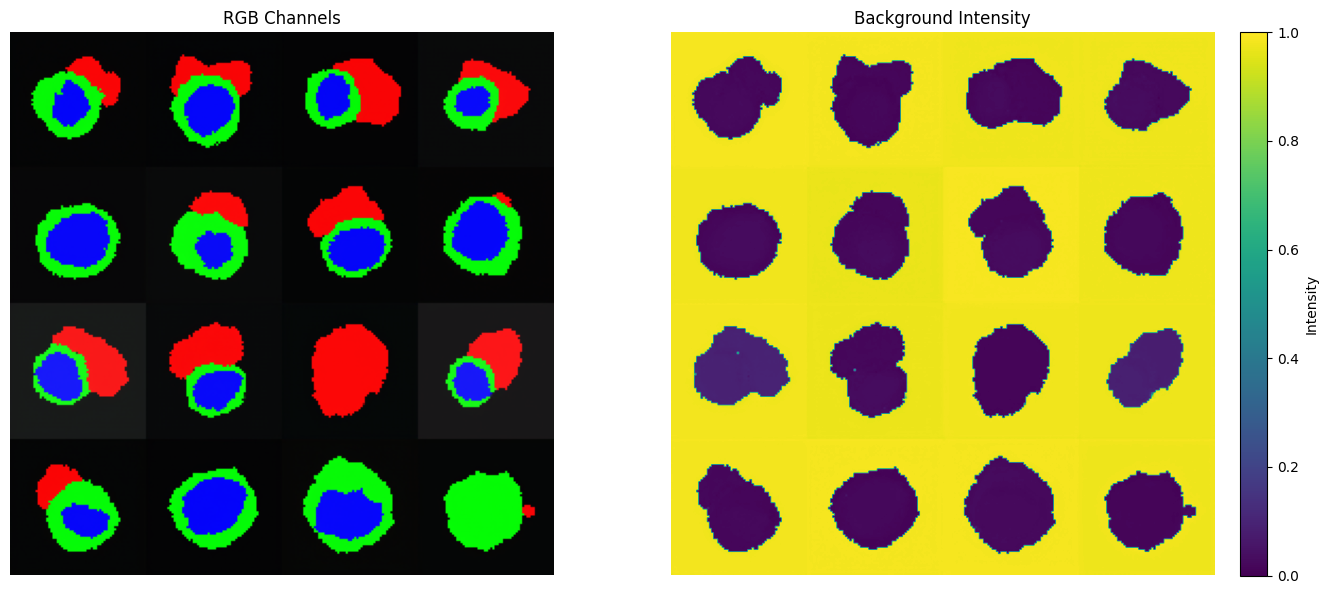

/tmp/ipykernel_1908448/300600383.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(torch.permute(make_grid(normalize_tensor_per_image(batch), nrow=int(np.sqrt(len(batch))), padding=0), (1,2,0)).cpu())


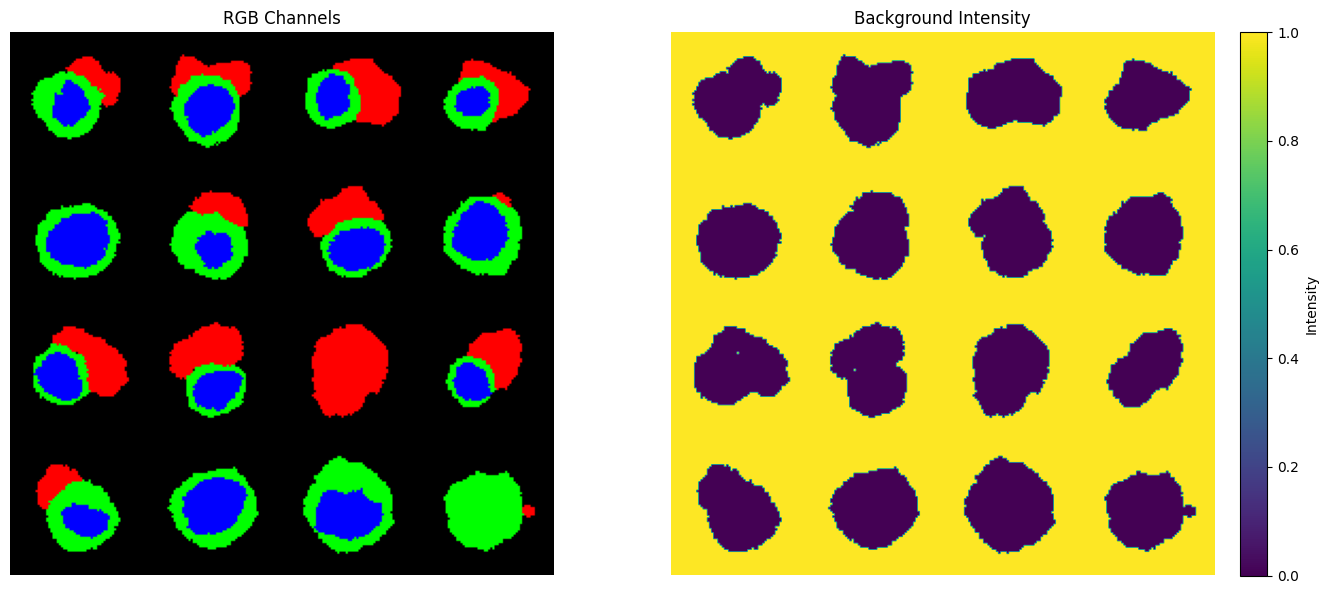

In [55]:
print("check generation:")
list_gen_imgs = sampling(model, (batch_size, channels, image_size, image_size), T, constants_dict)
show_images(list_gen_imgs[-1][:], OUTPUT_SAVE_PATH, one_hot_encode=False)
show_images(list_gen_imgs[-1][:], OUTPUT_ONE_HOT_SAVE_PATH, one_hot_encode=True)

/tmp/ipykernel_1908448/2522349631.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  frames = [np.array(torch.permute(make_grid(normalize_tensor_per_image(tens_im), nrow=int(np.sqrt(batch_size))), (1,2,0)).cpu()) for tens_im in frame_list]


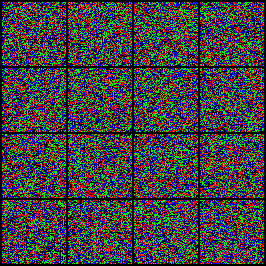

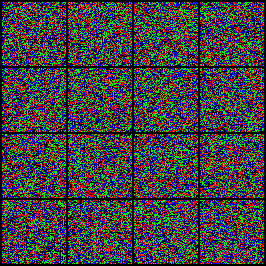

In [58]:
display(make_gif(list_gen_imgs, OUTPUT_GIF_ONE_HOT_SAVE_PATH, step=20))
display(make_gif(list_gen_imgs, OUTPUT_GIF_SAVE_PATH, step=20))

In [ ]:
generated_images = []
for _ in tqdm(range(100), desc='Generating images'):
    sample = sampling(model, (batch_size, channels, image_size, image_size), T, constants_dict)
    for image in sample[-1][:]:
        generated_images.append(image)